In [1]:
!pip install scikit-image ipywidgets lpips

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 12.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-10.

# Setup - Installing and Importing Libraries
This first cell installs and imports all the necessary Python libraries for our analysis. We need numpy for data handling, matplotlib for plotting, and scikit-image and lpips for our image quality metrics.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import lpips 
from tqdm import tqdm
import torch.nn.functional as F

print("Setup complete. All required libraries are imported.")

Setup complete. All required libraries are imported.


# Configuration and Data Loading
In this step, we define the paths to all our data files based on your screenshot. We will load the denoised results from both models and the ground truth data. Since the "mask-ana" model produced 128 slices, we will trim it to 100 to ensure a fair, slice-by-slice comparison with the "v3" model.

In [3]:
import os
import numpy as np

base_path_arch_imp = '/kaggle/input/architecture-improvements/'
base_path_mask_ana = '/kaggle/input/mask-ana-128-slices/'
base_path_sr3 = '/kaggle/input/new-sr3-temporal'
base_path_v3 = '/kaggle/input/new-sr3'
base_path_input = "/kaggle/input/new-noisy-input"

dbps_model_path = '/kaggle/input/dbps-v01/pytorch/default/1/dbps_model_v01.pth'

# Modell 1: architecture-improvements
model1_denoised_path = os.path.join(base_path_arch_imp, 'denoised_100_slices.npy')
model1_gt_path = os.path.join(base_path_arch_imp, 'gt_100_slices.npy') # Zugehörige GT-Datei
model1_name = 'Arch-Imp Model'

# Modell 2: mask-as-condition
model2_denoised_path = os.path.join(base_path_mask_ana, 'mask_ana_denoised_slices_00001-00128.npy')
model2_name = 'Mask as Condition Model'
# Hinweis: Für dieses Modell wird die GT-Datei von einem anderen Modell für den Vergleich verwendet.

# Modell 3: sr3-with-temporal
model3_denoised_path = os.path.join(base_path_sr3, 'denoised_slices_00001-00100.npy')
model3_gt_path = os.path.join(base_path_sr3, 'gt_slices_00001-00100.npy') # Zugehörige GT-Datei
model3_name = 'SR3+T Model'

# Modell 4: v3-100-slices
model4_denoised_path = os.path.join(base_path_v3, 'denoised_slices_00001-00100.npy')
model4_gt_path = os.path.join(base_path_v3, 'gt_slices_00001-00100.npy') # Dies wird als Referenz-GT verwendet
model4_name = 'v3 Model'

# Noisy Input
noisy_input_path = os.path.join(base_path_input, 'noisy_slices_00001-00100.npy')


# --- Laden und Vorbereiten der Daten ---
try:
    # Lade die "denoised" Daten aller vier Modelle
    denoised_model1 = np.load(model1_denoised_path)
    denoised_model2_full = np.load(model2_denoised_path) # Dies ist das Modell mit 128 Slices
    denoised_model3 = np.load(model3_denoised_path)
    denoised_model4 = np.load(model4_denoised_path)
    ground_truth = np.load(model4_gt_path)
    noisy_input = np.load(noisy_input_path)
    num_slices_to_compare = 100
    denoised_model2 = denoised_model2_full[:num_slices_to_compare]
    denoised_model2 = np.squeeze(denoised_model2)
    denoised_model1 = np.squeeze(denoised_model1)
    denoised_model3 = np.squeeze(denoised_model3)
    denoised_model4 = np.squeeze(denoised_model4)
    
    print(f"Denoised M1 ({model1_name}): {denoised_model1.shape}")
    print(f"Denoised M2 ({model2_name}): {denoised_model2.shape}")
    print(f"Denoised M3 ({model3_name}): {denoised_model3.shape}")
    print(f"Denoised M4 ({model4_name}): {denoised_model4.shape}")
    print(f"Ground Truth (GT) Shape: {ground_truth.shape}")
    print(f"Npisy Input Shape: {noisy_input.shape}")

except Exception as e:
    print(f"Ein Fehler ist beim Laden der Daten aufgetreten: {e}")

Denoised M1 (Arch-Imp Model): (100, 64, 64)
Denoised M2 (Mask as Condition Model): (100, 64, 64)
Denoised M3 (SR3+T Model): (100, 64, 64)
Denoised M4 (v3 Model): (100, 64, 64)
Ground Truth (GT) Shape: (100, 64, 64)
Npisy Input Shape: (100, 64, 64)


# Interactive Slice-by-Slice Visualization
This block allows for a direct visual comparison of the results. You can change the slice_to_view variable to inspect any of the 100 slices. It will display the output of both models side-by-side with the ground truth image for reference.

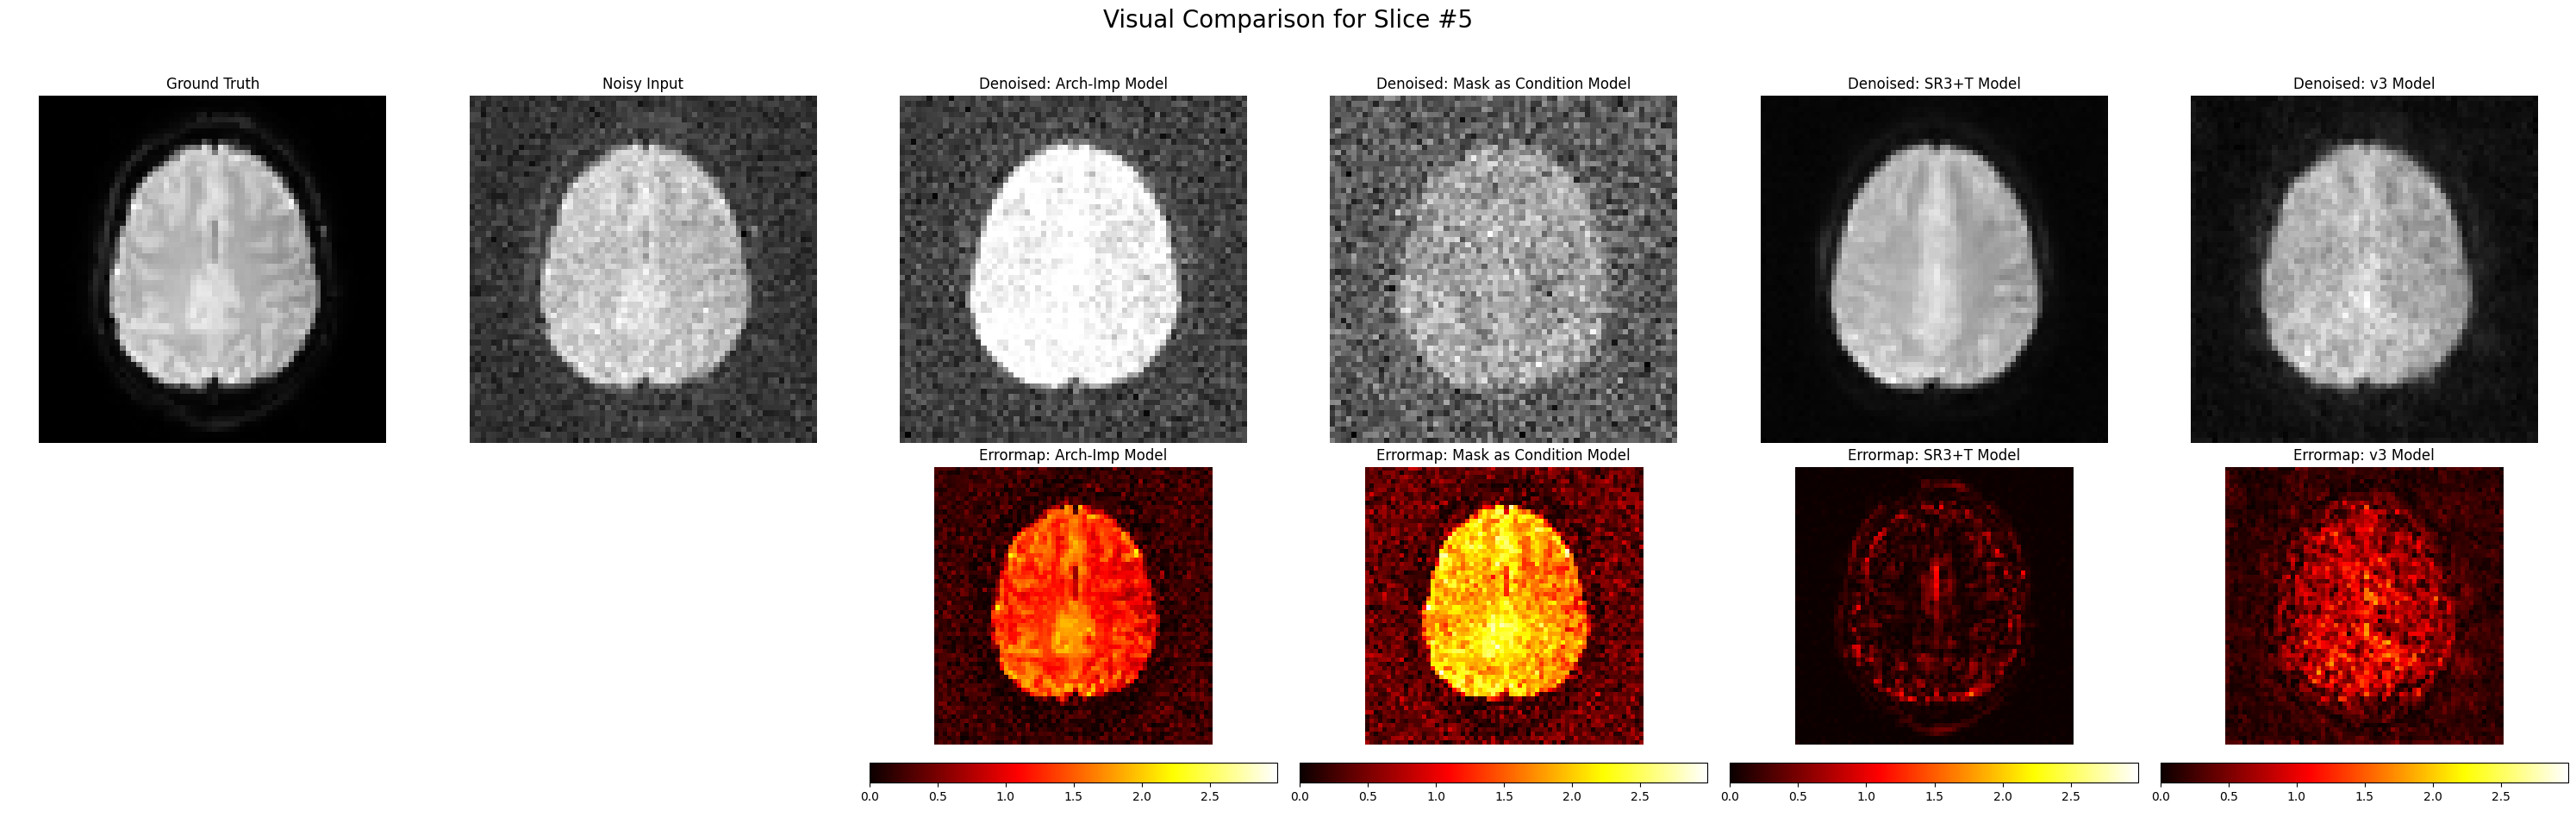

In [4]:
import matplotlib.pyplot as plt
import numpy as np

slice_to_view = 5 # Du kannst hier einen beliebigen Slice-Index zwischen 0 und 99 wählen

if 0 <= slice_to_view < num_slices_to_compare:
    # Lade die einzelnen Slices für den Vergleich
    gt_s = ground_truth[slice_to_view].squeeze()
    noisy_s = noisy_input[slice_to_view].squeeze() # HINZUGEFÜGT: Noisy Input Slice laden
    denoised1_s = denoised_model1[slice_to_view].squeeze()
    denoised2_s = denoised_model2[slice_to_view].squeeze()
    denoised3_s = denoised_model3[slice_to_view].squeeze()
    denoised4_s = denoised_model4[slice_to_view].squeeze()

    # Berechne die Fehlerkarten
    error_map1 = np.abs(gt_s - denoised1_s)
    error_map2 = np.abs(gt_s - denoised2_s)
    error_map3 = np.abs(gt_s - denoised3_s)
    error_map4 = np.abs(gt_s - denoised4_s)

    # Gemeinsame Farbskala für die Fehlerkarten
    max_error = max(error_map1.max(), error_map2.max(), error_map3.max(), error_map4.max())

    # HINZUGEFÜGT: Plot-Layout auf 2x6 erweitert und Figurengröße angepasst
    fig, axes = plt.subplots(2, 6, figsize=(30, 10)) 
    fig.suptitle(f'Visual Comparison for Slice #{slice_to_view}', fontsize=20)

    # --- ZEILE 1: BILDER ---

    # Spalte 1: Ground Truth
    axes[0, 0].imshow(gt_s, cmap='gray')
    axes[0, 0].set_title('Ground Truth')
    axes[0, 0].axis('off')

    # Spalte 2: Noisy Input (NEU)
    axes[0, 1].imshow(noisy_s, cmap='gray')
    axes[0, 1].set_title('Noisy Input')
    axes[0, 1].axis('off')

    # Spalte 3: Denoised Modell 1 (Position angepasst)
    axes[0, 2].imshow(denoised1_s, cmap='gray')
    axes[0, 2].set_title(f'Denoised: {model1_name}')
    axes[0, 2].axis('off')

    # Spalte 4: Denoised Modell 2 (Position angepasst)
    axes[0, 3].imshow(denoised2_s, cmap='gray')
    axes[0, 3].set_title(f'Denoised: {model2_name}')
    axes[0, 3].axis('off')

    # Spalte 5: Denoised Modell 3 (Position angepasst)
    axes[0, 4].imshow(denoised3_s, cmap='gray')
    axes[0, 4].set_title(f'Denoised: {model3_name}')
    axes[0, 4].axis('off')

    # Spalte 6: Denoised Modell 4 (Position angepasst)
    axes[0, 5].imshow(denoised4_s, cmap='gray')
    axes[0, 5].set_title(f'Denoised: {model4_name}')
    axes[0, 5].axis('off')
    
    # --- ZEILE 2: FEHLERKARTEN ---

    # Leere die ersten beiden Spalten in der zweiten Zeile
    axes[1, 0].axis('off')
    axes[1, 1].axis('off') # HINZUGEFÜGT

    # Fehlerkarte 1 (Position angepasst)
    im1 = axes[1, 2].imshow(error_map1, cmap='hot', vmin=0, vmax=max_error)
    axes[1, 2].set_title(f'Errormap: {model1_name}')
    axes[1, 2].axis('off')
    fig.colorbar(im1, ax=axes[1, 2], orientation='horizontal', pad=0.05)

    # Fehlerkarte 2 (Position angepasst)
    im2 = axes[1, 3].imshow(error_map2, cmap='hot', vmin=0, vmax=max_error)
    axes[1, 3].set_title(f'Errormap: {model2_name}')
    axes[1, 3].axis('off')
    fig.colorbar(im2, ax=axes[1, 3], orientation='horizontal', pad=0.05)

    # Fehlerkarte 3 (Position angepasst)
    im3 = axes[1, 4].imshow(error_map3, cmap='hot', vmin=0, vmax=max_error)
    axes[1, 4].set_title(f'Errormap: {model3_name}')
    axes[1, 4].axis('off')
    fig.colorbar(im3, ax=axes[1, 4], orientation='horizontal', pad=0.05)

    # Fehlerkarte 4 (Position angepasst)
    im4 = axes[1, 5].imshow(error_map4, cmap='hot', vmin=0, vmax=max_error)
    axes[1, 5].set_title(f'Errormap: {model4_name}')
    axes[1, 5].axis('off')
    fig.colorbar(im4, ax=axes[1, 5], orientation='horizontal', pad=0.05)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
else:
    print(f"\nFehler: Ungültiger Slice-Index. Bitte wähle einen Index zwischen 0 und {num_slices_to_compare - 1}.")

# Slice-wise Quantitative Analysis (PSNR, SSIM, DBPS)
Here, we perform the main quantitative evaluation. We first load your custom-trained DBPS (LPIPS) model. Then, we loop through all 100 slices and calculate PSNR, SSIM, and the DBPS distance for both denoising models. Finally, we plot these metrics to visualize the performance across the entire dataset.

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FeatureExtractor(nn.Module):
    """
    A simple convolutional neural network to extract multi-level features from an image.
    This network consists of four sequential convolutional blocks, each of which
    downsamples the input and increases the number of feature channels.
    """
    def __init__(self):
        """
        Initializes the layers of the feature extractor.
        """
        super(FeatureExtractor, self).__init__()
        
        # Block 1: 1 input channel -> 16 output channels. Spatial size is maintained (due to padding).
        # Input shape example: [batch, 1, H, W]
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        
        # Block 2: 16 -> 32 channels. Spatial size is halved (stride=2).
        # Input shape example: [batch, 16, H, W] -> Output shape: [batch, 32, H/2, W/2]
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        
        # Block 3: 32 -> 64 channels. Spatial size is halved again.
        # Input shape example: [batch, 32, H/2, W/2] -> Output shape: [batch, 64, H/4, W/4]
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=2)
        self.bn3 = nn.BatchNorm2d(64)
        
        # Block 4: 64 -> 128 channels. Spatial size is halved a final time.
        # Input shape example: [batch, 64, H/4, W/4] -> Output shape: [batch, 128, H/8, W/8]
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=2)
        self.bn4 = nn.BatchNorm2d(128)

    def forward(self, x):
        """
        Defines the forward pass of the network.
        It processes the input tensor 'x' and returns a list of feature maps
        from the intermediate layers.
        
        Args:
            x (torch.Tensor): The input image tensor.
        
        Returns:
            list[torch.Tensor]: A list of four feature maps [h1, h2, h3, h4].
        """
        h1 = F.relu(self.bn1(self.conv1(x)))
        h2 = F.relu(self.bn2(self.conv2(h1)))
        h3 = F.relu(self.bn3(self.conv3(h2)))
        h4 = F.relu(self.bn4(self.conv4(h3)))
        return [h1, h2, h3, h4]

class PerceptualLoss(nn.Module):
    def __init__(self, model, use_gpu=True):
        super(PerceptualLoss, self).__init__()
        self.net = model
        self.net.eval()  # Set the network to evaluation mode
        if use_gpu and torch.cuda.is_available():
            self.net.cuda()

    def forward(self, x, y):
        # Extract feature maps for both input tensors
        feats_x = self.net(x)
        feats_y = self.net(y)
        
        # Initialize the total score (loss)
        score = 0
        
        # Iterate over the feature maps from each layer
        for fx, fy in zip(feats_x, feats_y):
            # Normalize each feature map across the channel dimension (L2 normalization).
            # This makes the comparison sensitive to feature orientation rather than magnitude.
            # A small epsilon (1e-10) is added for numerical stability.
            fx_norm = fx / (torch.sqrt(torch.sum(fx**2, dim=1, keepdim=True)) + 1e-10)
            fy_norm = fy / (torch.sqrt(torch.sum(fy**2, dim=1, keepdim=True)) + 1e-10)
            
            # Calculate the difference between the normalized features
            diff = fx_norm - fy_norm
            
            # Calculate the spatial average of the squared difference
            # 1. Square the difference
            # 2. Sum across channels (dim=1) to get a 2D error map
            # 3. Average across spatial dimensions (height and width) to get a single value per image
            dist = (diff**2).sum(dim=1).mean(dim=[1, 2]) # A more direct way to average over H and W
            
            # Accumulate the distance from this layer to the total score
            score += dist
            
        return score

print("DBPS model classes ('FeatureExtractor', 'PerceptualLoss') are now defined.")

DBPS model classes ('FeatureExtractor', 'PerceptualLoss') are now defined.


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

feature_extractor = FeatureExtractor().to(device)
# Load the pre-trained weights, ensuring they are mapped to the correct device
feature_extractor.load_state_dict(torch.load(dbps_model_path, map_location=device))

# Instantiate the perceptual loss metric, which uses the feature extractor
dbps_metric = PerceptualLoss(model=feature_extractor, use_gpu=torch.cuda.is_available()).to(device)
# Set the metric model to evaluation mode (disables dropout, batch norm updates, etc.)
dbps_metric.eval()
print(f"Custom DBPS metric model loaded successfully on device: {device}")

# --- Metric Evaluation ---
print("\nCalculating PSNR, SSIM & DBPS for all slices...")

# Initialize lists to store metrics for each of the four models
psnr_m1, ssim_m1, lpips_m1 = [], [], []
psnr_m2, ssim_m2, lpips_m2 = [], [], []
psnr_m3, ssim_m3, lpips_m3 = [], [], [] # NEW: For model 3
psnr_m4, ssim_m4, lpips_m4 = [], [], [] # NEW: For model 4

# Loop through each slice to calculate and compare metrics
for i in tqdm(range(num_slices_to_compare), desc="Calculating Metrics"):
    # --- Get Slices (Numpy) ---
    # Extract the i-th slice for the ground truth and all four models
    gt_slice_np = ground_truth[i]
    denoised1_np = denoised_model1[i]
    denoised2_np = denoised_model2[i]
    denoised3_np = denoised_model3[i] # NEW: Get slice for model 3
    denoised4_np = denoised_model4[i] # NEW: Get slice for model 4
    
    # Calculate the data range for PSNR and SSIM, which is required for normalized images
    data_range = gt_slice_np.max() - gt_slice_np.min()

    # --- PSNR & SSIM Calculation (using scikit-image) ---
    # Model 1
    psnr_m1.append(peak_signal_noise_ratio(gt_slice_np, denoised1_np, data_range=data_range))
    ssim_m1.append(structural_similarity(gt_slice_np, denoised1_np, data_range=data_range, channel_axis=None)) # Use channel_axis=None for 2D images
    # Model 2
    psnr_m2.append(peak_signal_noise_ratio(gt_slice_np, denoised2_np, data_range=data_range))
    ssim_m2.append(structural_similarity(gt_slice_np, denoised2_np, data_range=data_range, channel_axis=None))
    # Model 3
    psnr_m3.append(peak_signal_noise_ratio(gt_slice_np, denoised3_np, data_range=data_range))
    ssim_m3.append(structural_similarity(gt_slice_np, denoised3_np, data_range=data_range, channel_axis=None))
    # Model 4
    psnr_m4.append(peak_signal_noise_ratio(gt_slice_np, denoised4_np, data_range=data_range))
    ssim_m4.append(structural_similarity(gt_slice_np, denoised4_np, data_range=data_range, channel_axis=None))

    # --- DBPS Calculation (using PyTorch) ---
    # Helper function to convert a 2D numpy slice to a 4D torch tensor for the metric model
    def to_metric_tensor(slice_np):
        # Converts numpy array [H, W] to torch tensor [1, 1, H, W] and moves to device
        return torch.from_numpy(slice_np).float().unsqueeze(0).unsqueeze(0).to(device)

    # Convert all numpy slices to torch tensors
    gt_tensor = to_metric_tensor(gt_slice_np)
    d1_tensor = to_metric_tensor(denoised1_np)
    d2_tensor = to_metric_tensor(denoised2_np)
    d3_tensor = to_metric_tensor(denoised3_np) # NEW: Tensor for model 3
    d4_tensor = to_metric_tensor(denoised4_np) # NEW: Tensor for model 4

    # Calculate DBPS within a no_grad context to disable gradient computation
    with torch.no_grad():
        lpips_m1.append(dbps_metric(gt_tensor, d1_tensor).item())
        lpips_m2.append(dbps_metric(gt_tensor, d2_tensor).item())
        lpips_m3.append(dbps_metric(gt_tensor, d3_tensor).item()) # NEW: DBPS for model 3
        lpips_m4.append(dbps_metric(gt_tensor, d4_tensor).item()) # NEW: DBPS for model 4

# --- Summary Output ---
print("\n--- Average Performance Metrics ---")
# Print the average scores for each model, now including models 3 and 4
print(f"[{model1_name}]:\n  - Avg PSNR: {np.mean(psnr_m1):.2f} dB | Avg SSIM: {np.mean(ssim_m1):.4f} | Avg DBPS: {np.mean(lpips_m1):.4f}")
print(f"[{model2_name}]:\n  - Avg PSNR: {np.mean(psnr_m2):.2f} dB | Avg SSIM: {np.mean(ssim_m2):.4f} | Avg DBPS: {np.mean(lpips_m2):.4f}")
print(f"[{model3_name}]:\n  - Avg PSNR: {np.mean(psnr_m3):.2f} dB | Avg SSIM: {np.mean(ssim_m3):.4f} | Avg DBPS: {np.mean(lpips_m3):.4f}") # NEW
print(f"[{model4_name}]:\n  - Avg PSNR: {np.mean(psnr_m4):.2f} dB | Avg SSIM: {np.mean(ssim_m4):.4f} | Avg DBPS: {np.mean(lpips_m4):.4f}") # NEW

Custom DBPS metric model loaded successfully on device: cpu

Calculating PSNR, SSIM & DBPS for all slices...


Calculating Metrics: 100%|██████████| 100/100 [00:01<00:00, 56.86it/s]


--- Average Performance Metrics ---
[Arch-Imp Model]:
  - Avg PSNR: 16.66 dB | Avg SSIM: 0.4517 | Avg DBPS: 1.9463
[Mask as Condition Model]:
  - Avg PSNR: 18.75 dB | Avg SSIM: 0.4695 | Avg DBPS: 1.7179
[SR3+T Model]:
  - Avg PSNR: 27.10 dB | Avg SSIM: 0.7899 | Avg DBPS: 0.3672
[v3 Model]:
  - Avg PSNR: 19.05 dB | Avg SSIM: 0.5048 | Avg DBPS: 1.8246


# Visualization of Results
This final section creates the visualizations. First, we plot the performance curves for all three metrics over the slices. Second, we create a detailed comparison for a single, user-selectable slice, including the error maps that highlight where each model deviates most from the ground truth.

--- Smoothing metric data for visualization... ---
--- Plotting metric performance in two separate rows... ---


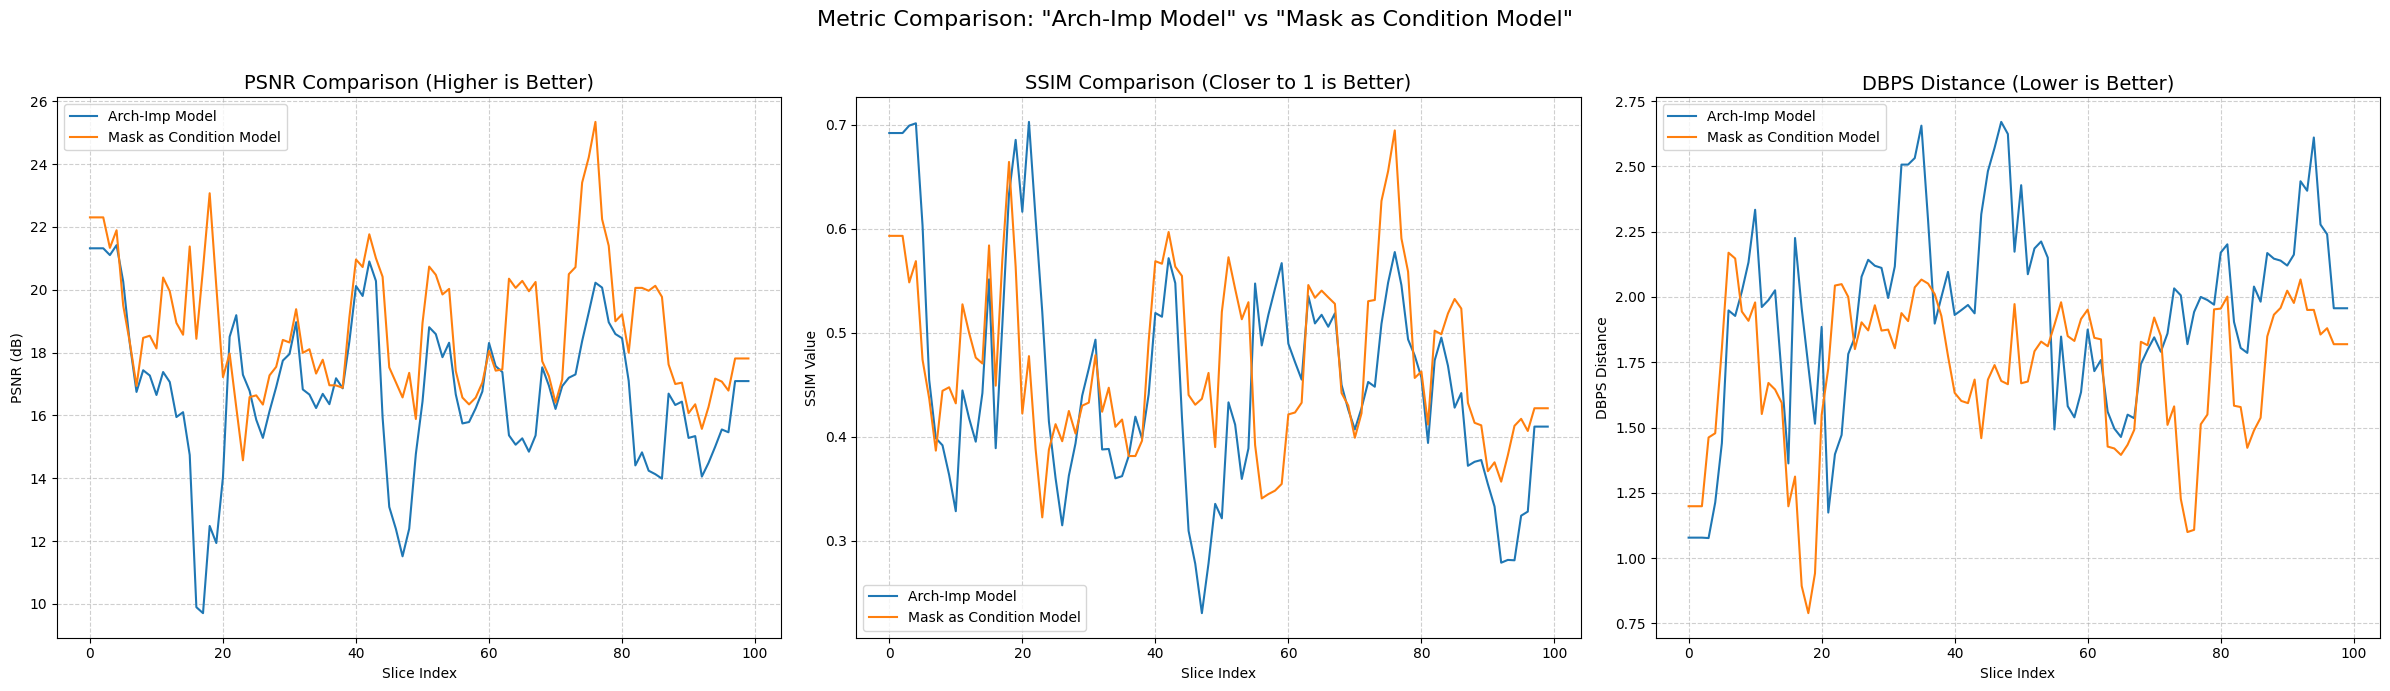

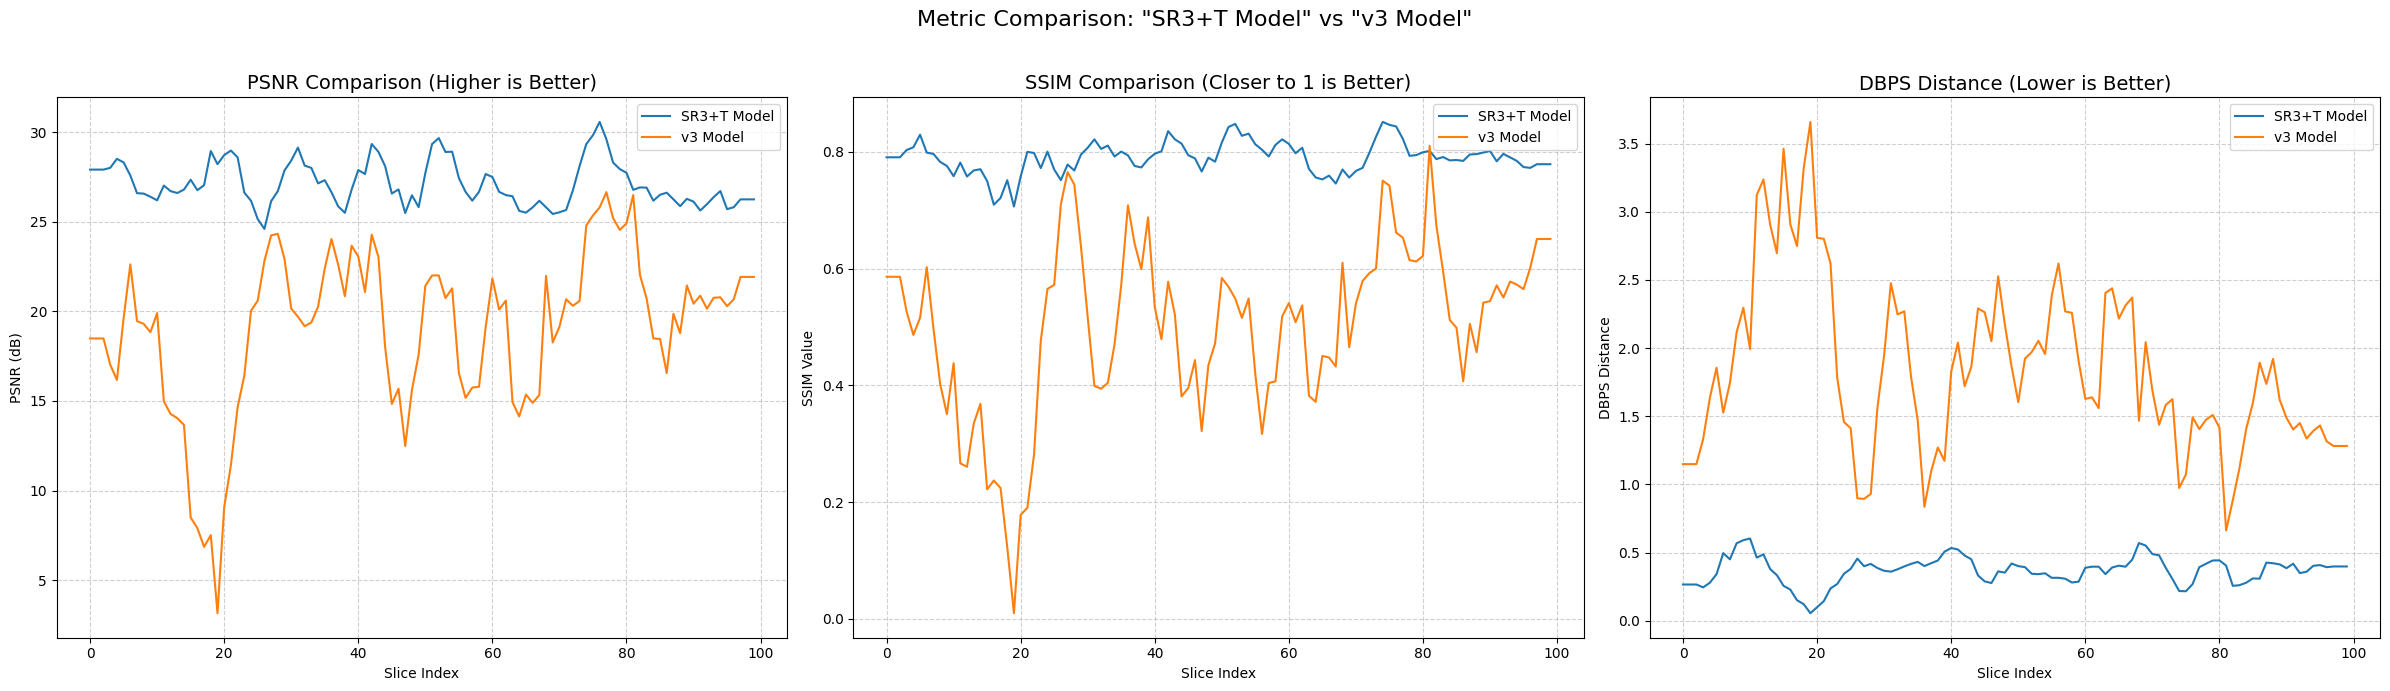

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# The smoothing function remains the same.
def smooth_curve(values, window_size=5):
    """
    Smooth a 1D array using a simple moving average.
    """
    smoothed = np.convolve(values, np.ones(window_size) / window_size, mode='valid')
    pad_width = (len(values) - len(smoothed)) // 2
    return np.pad(smoothed, (pad_width, len(values) - len(smoothed) - pad_width), 'edge')


# --- Smooth the metric data for all four models ---
# This part is unchanged as we still need all the data.
print("--- Smoothing metric data for visualization... ---")
# Model 1
psnr_m1_smooth = smooth_curve(psnr_m1)
ssim_m1_smooth = smooth_curve(ssim_m1)
lpips_m1_smooth = smooth_curve(lpips_m1)
# Model 2
psnr_m2_smooth = smooth_curve(psnr_m2)
ssim_m2_smooth = smooth_curve(ssim_m2)
lpips_m2_smooth = smooth_curve(lpips_m2)
# Model 3
psnr_m3_smooth = smooth_curve(psnr_m3)
ssim_m3_smooth = smooth_curve(ssim_m3)
lpips_m3_smooth = smooth_curve(lpips_m3)
# Model 4
psnr_m4_smooth = smooth_curve(psnr_m4)
ssim_m4_smooth = smooth_curve(ssim_m4)
lpips_m4_smooth = smooth_curve(lpips_m4)


# --- Create Plots ---
print("--- Plotting metric performance in two separate rows... ---")
slice_indices = range(num_slices_to_compare)

# ===================================================================
# --- ROW 1: Plotting Models 1 and 2 ---
# ===================================================================
fig1, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 7))
fig1.suptitle(f'Metric Comparison: "{model1_name}" vs "{model2_name}"', fontsize=16)

# Plot 1: PSNR (Higher is Better)
ax1.plot(slice_indices, psnr_m1_smooth, label=model1_name)
ax1.plot(slice_indices, psnr_m2_smooth, label=model2_name)
ax1.set_title('PSNR Comparison (Higher is Better)', fontsize=14)
ax1.set_xlabel('Slice Index'); ax1.set_ylabel('PSNR (dB)')
ax1.legend(); ax1.grid(True, linestyle='--', alpha=0.6)

# Plot 2: SSIM (Closer to 1 is Better)
ax2.plot(slice_indices, ssim_m1_smooth, label=model1_name)
ax2.plot(slice_indices, ssim_m2_smooth, label=model2_name)
ax2.set_title('SSIM Comparison (Closer to 1 is Better)', fontsize=14)
ax2.set_xlabel('Slice Index'); ax2.set_ylabel('SSIM Value')
ax2.legend(); ax2.grid(True, linestyle='--', alpha=0.6)

# Plot 3: DBPS (Lower is Better)
ax3.plot(slice_indices, lpips_m1_smooth, label=model1_name)
ax3.plot(slice_indices, lpips_m2_smooth, label=model2_name)
ax3.set_title('DBPS Distance (Lower is Better)', fontsize=14)
ax3.set_xlabel('Slice Index'); ax3.set_ylabel('DBPS Distance')
ax3.legend(); ax3.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout(rect=[0, 0, 1, 0.96])

# ===================================================================
# --- ROW 2: Plotting Models 3 and 4 ---
# ===================================================================
fig2, (ax4, ax5, ax6) = plt.subplots(1, 3, figsize=(24, 7))
fig2.suptitle(f'Metric Comparison: "{model3_name}" vs "{model4_name}"', fontsize=16)

# Plot 4: PSNR (Higher is Better)
ax4.plot(slice_indices, psnr_m3_smooth, label=model3_name)
ax4.plot(slice_indices, psnr_m4_smooth, label=model4_name)
ax4.set_title('PSNR Comparison (Higher is Better)', fontsize=14)
ax4.set_xlabel('Slice Index'); ax4.set_ylabel('PSNR (dB)')
ax4.legend(); ax4.grid(True, linestyle='--', alpha=0.6)

# Plot 5: SSIM (Closer to 1 is Better)
ax5.plot(slice_indices, ssim_m3_smooth, label=model3_name)
ax5.plot(slice_indices, ssim_m4_smooth, label=model4_name)
ax5.set_title('SSIM Comparison (Closer to 1 is Better)', fontsize=14)
ax5.set_xlabel('Slice Index'); ax5.set_ylabel('SSIM Value')
ax5.legend(); ax5.grid(True, linestyle='--', alpha=0.6)

# Plot 6: DBPS (Lower is Better)
ax6.plot(slice_indices, lpips_m3_smooth, label=model3_name)
ax6.plot(slice_indices, lpips_m4_smooth, label=model4_name)
ax6.set_title('DBPS Distance (Lower is Better)', fontsize=14)
ax6.set_xlabel('Slice Index'); ax6.set_ylabel('DBPS Distance')
ax6.legend(); ax6.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout(rect=[0, 0, 1, 0.96])

# Display both figures
plt.show()

# Temporal Signal-to-Noise Ratio (tSNR) Analysis
This final block is dedicated to the tSNR metric. As you correctly noted, this metric requires the entire time-series at once. We will first define the function to compute the tSNR map from a 4D volume, as described in your evaluation.ipynb notebook. Then, we will reshape our loaded data back into 4D volumes and compute and visualize the tSNR maps for the ground truth and both model outputs. A higher tSNR value (brighter areas in the map) indicates better signal stability over time.

--- Calculating and preparing tSNR maps for all models ---
Reshaped data for tSNR calculation to shape (H, W, Z, T): (64, 64, 1, 100)

--- Visualizing tSNR for Models 1 & 2 ---


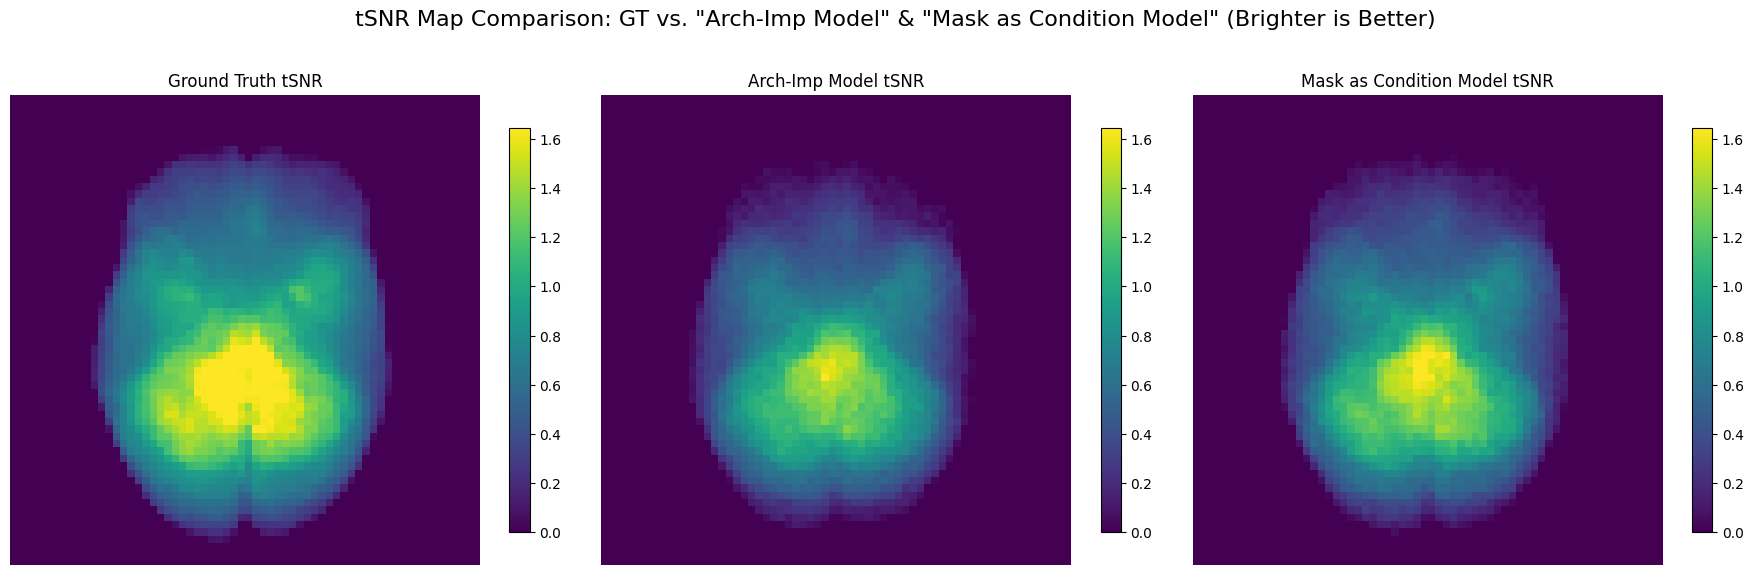

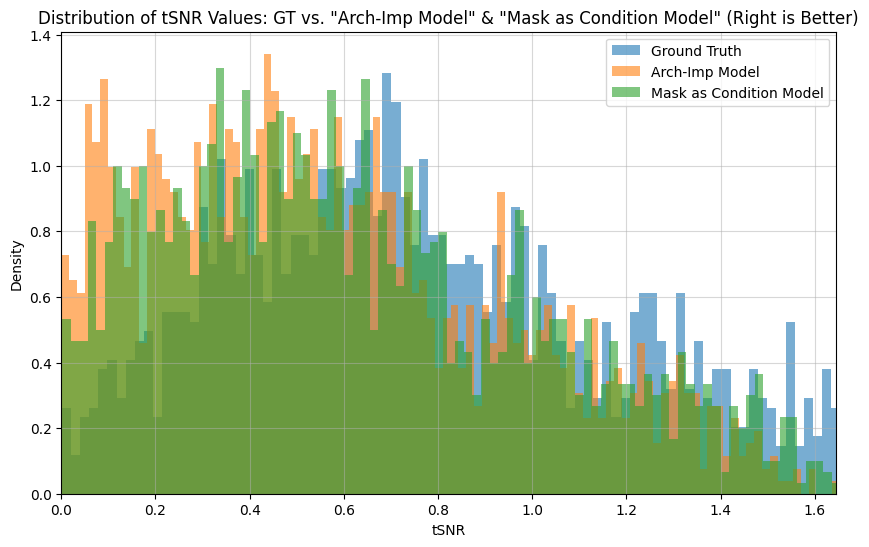


--- Visualizing tSNR for Models 3 & 4 ---


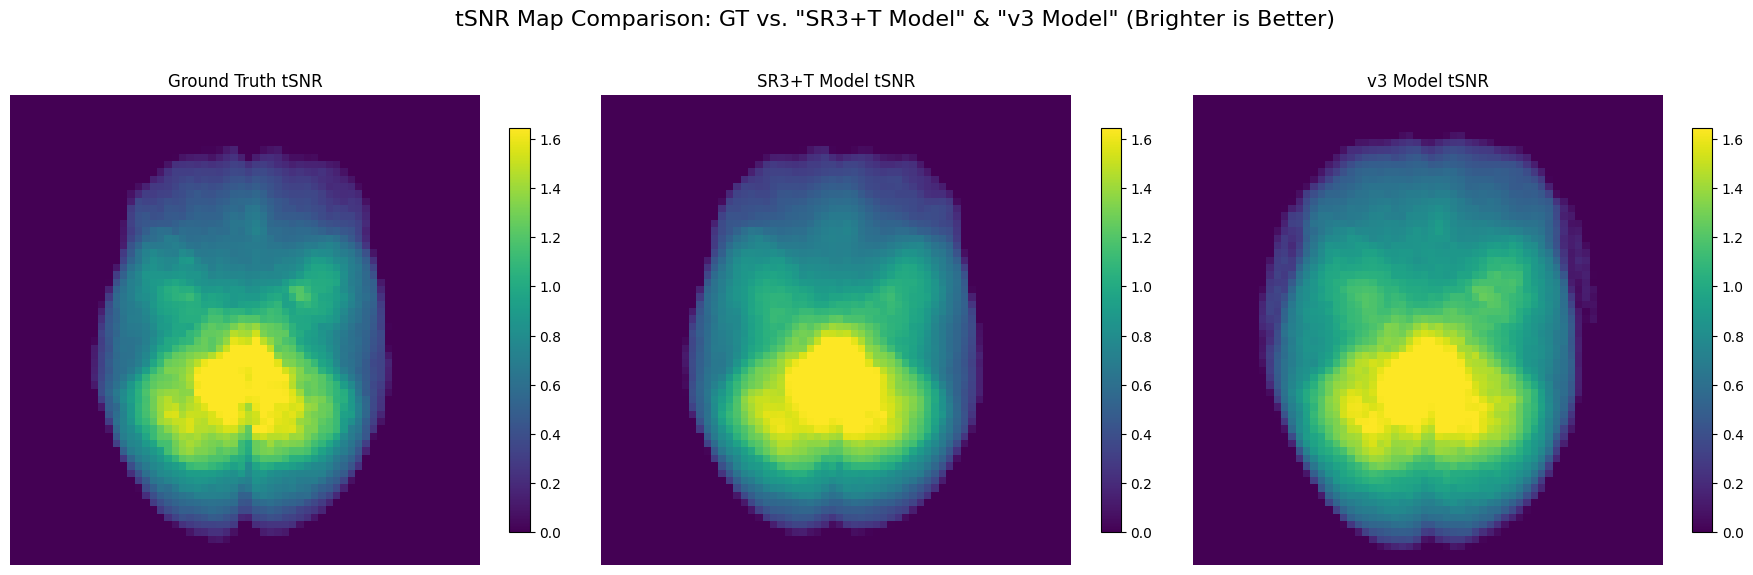

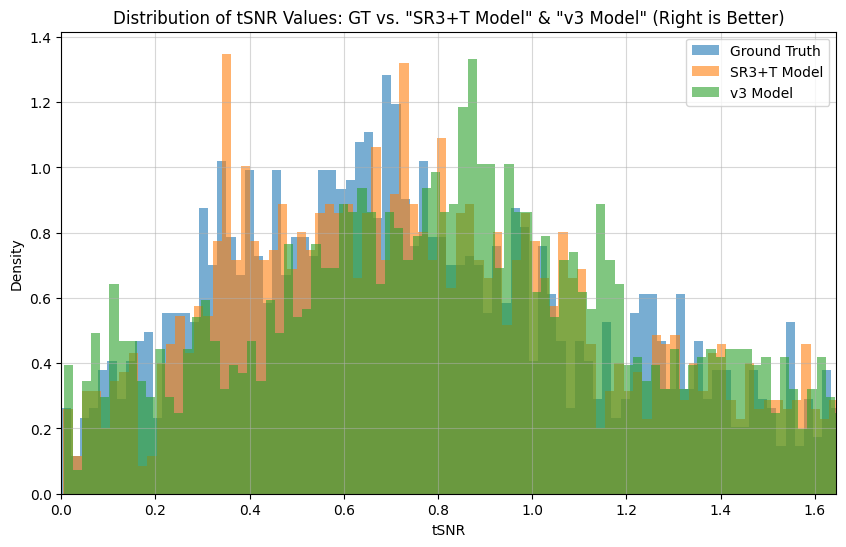

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def compute_tsnr(data_volume, max_clip=100):
    """
    Computes the temporal Signal-to-Noise Ratio (tSNR) for a 4D volume.
    The time dimension is assumed to be the last axis. Clips outlier values.
    
    Args:
        data_volume (np.array): 4D numpy array (H, W, Z, T).
        max_clip (int): Maximum tSNR value before clipping to improve visualization.
        
    Returns:
        np.array: A 3D numpy array representing the tSNR map.
    """
    # Calculate mean and standard deviation along the time axis (axis=3)
    mean_signal = np.nanmean(data_volume, axis=3)
    std_signal = np.nanstd(data_volume, axis=3)
    
    # Supress divide-by-zero warnings for background voxels
    with np.errstate(divide='ignore', invalid='ignore'):
        tsnr_map = np.divide(mean_signal, std_signal)
        # Set non-finite values (NaN, inf) resulting from division by zero to 0
        tsnr_map[~np.isfinite(tsnr_map)] = 0

    # Clip high values to prevent outliers from skewing the color map
    tsnr_map = np.clip(tsnr_map, 0, max_clip)
    return tsnr_map


# --- Reshape data and compute tSNR for ALL models ---
print("--- Calculating and preparing tSNR maps for all models ---")
# The original data shape is (slices, H, W). We treat slices as the time dimension (T).
# We reshape to (H, W, Z, T), where Z is a singleton dimension.
# transpose(1, 2, 0) changes (T, H, W) -> (H, W, T)
gt_4d = ground_truth.transpose(1, 2, 0)[:, :, np.newaxis, :]
denoised1_4d = denoised_model1.transpose(1, 2, 0)[:, :, np.newaxis, :]
denoised2_4d = denoised_model2.transpose(1, 2, 0)[:, :, np.newaxis, :]
denoised3_4d = denoised_model3.transpose(1, 2, 0)[:, :, np.newaxis, :] # NEW
denoised4_4d = denoised_model4.transpose(1, 2, 0)[:, :, np.newaxis, :] # NEW

print(f"Reshaped data for tSNR calculation to shape (H, W, Z, T): {gt_4d.shape}")

# Compute tSNR maps for all datasets and squeeze out the singleton Z dimension
tsnr_gt = compute_tsnr(gt_4d).squeeze()
tsnr_m1 = compute_tsnr(denoised1_4d).squeeze()
tsnr_m2 = compute_tsnr(denoised2_4d).squeeze()
tsnr_m3 = compute_tsnr(denoised3_4d).squeeze() # NEW
tsnr_m4 = compute_tsnr(denoised4_4d).squeeze() # NEW


# ===================================================================
# --- Visualization Part 1: Ground Truth vs. Model 1 & 2 ---
# ===================================================================
print("\n--- Visualizing tSNR for Models 1 & 2 ---")
# --- Visualize the tSNR maps ---
fig1, axes1 = plt.subplots(1, 3, figsize=(18, 6))
fig1.suptitle(f'tSNR Map Comparison: GT vs. "{model1_name}" & "{model2_name}" (Brighter is Better)', fontsize=16)

# Use a common, sensible range for the color bar (e.g., vmin=0, vmax=100) or adjust as needed
vmax_val = np.percentile(tsnr_gt, 98) # Use 98th percentile of GT for a robust max value

im_gt = axes1[0].imshow(tsnr_gt, cmap='viridis', vmin=0, vmax=vmax_val)
axes1[0].set_title('Ground Truth tSNR')
axes1[0].axis('off')
fig1.colorbar(im_gt, ax=axes1[0], shrink=0.8)

im_m1 = axes1[1].imshow(tsnr_m1, cmap='viridis', vmin=0, vmax=vmax_val)
axes1[1].set_title(f'{model1_name} tSNR')
axes1[1].axis('off')
fig1.colorbar(im_m1, ax=axes1[1], shrink=0.8)

im_m2 = axes1[2].imshow(tsnr_m2, cmap='viridis', vmin=0, vmax=vmax_val)
axes1[2].set_title(f'{model2_name} tSNR')
axes1[2].axis('off')
fig1.colorbar(im_m2, ax=axes1[2], shrink=0.8)

plt.tight_layout(rect=[0, 0, 1, 0.95])

# --- Visualize tSNR Histograms ---
plt.figure(figsize=(10, 6))
# Create masks to exclude background noise from the histogram
mask_gt = tsnr_gt > np.percentile(tsnr_gt, 25) # More robust mask
mask_m1 = tsnr_m1 > np.percentile(tsnr_m1, 25)
mask_m2 = tsnr_m2 > np.percentile(tsnr_m2, 25)

plt.hist(tsnr_gt[mask_gt].flatten(), bins=100, alpha=0.6, label='Ground Truth', density=True)
plt.hist(tsnr_m1[mask_m1].flatten(), bins=100, alpha=0.6, label=model1_name, density=True)
plt.hist(tsnr_m2[mask_m2].flatten(), bins=100, alpha=0.6, label=model2_name, density=True)

plt.title(f'Distribution of tSNR Values: GT vs. "{model1_name}" & "{model2_name}" (Right is Better)')
plt.xlabel('tSNR'); plt.ylabel('Density')
plt.legend(); plt.grid(True, alpha=0.5)
plt.xlim(0, vmax_val) # Set x-limit based on the determined vmax
plt.show()


# ===================================================================
# --- Visualization Part 2: Ground Truth vs. Model 3 & 4 ---
# ===================================================================
print("\n--- Visualizing tSNR for Models 3 & 4 ---")
# --- Visualize the tSNR maps ---
fig2, axes2 = plt.subplots(1, 3, figsize=(18, 6))
fig2.suptitle(f'tSNR Map Comparison: GT vs. "{model3_name}" & "{model4_name}" (Brighter is Better)', fontsize=16)

im_gt2 = axes2[0].imshow(tsnr_gt, cmap='viridis', vmin=0, vmax=vmax_val)
axes2[0].set_title('Ground Truth tSNR')
axes2[0].axis('off')
fig2.colorbar(im_gt2, ax=axes2[0], shrink=0.8)

im_m3 = axes2[1].imshow(tsnr_m3, cmap='viridis', vmin=0, vmax=vmax_val)
axes2[1].set_title(f'{model3_name} tSNR')
axes2[1].axis('off')
fig2.colorbar(im_m3, ax=axes2[1], shrink=0.8)

im_m4 = axes2[2].imshow(tsnr_m4, cmap='viridis', vmin=0, vmax=vmax_val)
axes2[2].set_title(f'{model4_name} tSNR')
axes2[2].axis('off')
fig2.colorbar(im_m4, ax=axes2[2], shrink=0.8)

plt.tight_layout(rect=[0, 0, 1, 0.95])

# --- Visualize tSNR Histograms ---
plt.figure(figsize=(10, 6))
# Create masks to exclude background noise from the histogram
mask_m3 = tsnr_m3 > np.percentile(tsnr_m3, 25)
mask_m4 = tsnr_m4 > np.percentile(tsnr_m4, 25)

plt.hist(tsnr_gt[mask_gt].flatten(), bins=100, alpha=0.6, label='Ground Truth', density=True)
plt.hist(tsnr_m3[mask_m3].flatten(), bins=100, alpha=0.6, label=model3_name, density=True)
plt.hist(tsnr_m4[mask_m4].flatten(), bins=100, alpha=0.6, label=model4_name, density=True)

plt.title(f'Distribution of tSNR Values: GT vs. "{model3_name}" & "{model4_name}" (Right is Better)')
plt.xlabel('tSNR'); plt.ylabel('Density')
plt.legend(); plt.grid(True, alpha=0.5)
plt.xlim(0, vmax_val) # Set x-limit based on the determined vmax
plt.show()